These notebooks are used to compare a base and scenario, from surveys or model outputs, in H5 format. To run: from the menu bar above, choose **Cell -> Run All ** or run lines individually. Use the toggle button below to hide/show the raw Python code.

 ## School and Workplace Location Models

*Summaries for Daysim Models 1.1 - 1.5*

    - Workplace Location (1.1)
        - by County
        - by District
    - School Location (1.2)
        - by County
        - by District
    - Workers Paying to Park at Work (1.3)
        - by Workplace County
        - by Workplace District
    - Transit Pass Ownership (1.4)
       - by Workplace County 
       - by Workplace District
       - by Home County 
       - by Home District
    - Auto Ownership (1.5)
       - by County
       - by District
---

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [80]:
import os
import numpy as np
import pandas as pd
import h5py
import pylab as P
from IPython.display import display, display_pretty, Javascript, HTML
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# Show charts in notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [30]:
# Load h5 or daysim outputs records
# Refering to 2 datasets as BASE and SCEN (scenario)

base = h5py.File(r'R:\SoundCast\estimation\2014\P5\survey14.h5','r+')
base_name = '2014 Survey'

# Note that expansion factor on daysim_outputs = 1 for each record, to allow direct comparison between survey records w/ exp. factor
scen = h5py.File(r'R:\SoundCast\releases\TransportationFutures2010\outputs\daysim_outputs.h5','r+')
scen_name = 'Daysim'

In [3]:
def build_df(h5file, h5table, var_dict, nested):
    ''' Convert H5 into dataframe '''
    data = {}
    if nested:
        # survey h5 have nested data structure, different than daysim_outputs
        for col_name, var in var_dict.iteritems():
            data[col_name] = [i[0] for i in h5file[h5table][var][:]]
    else:
        for col_name, var in var_dict.iteritems():
            data[col_name] = [i for i in h5file[h5table][var][:]]

    return pd.DataFrame(data)

In [10]:
# Columns to import from h5 for analysis
tripdict={'Household ID': 'hhno',
            'Person Number': 'pno',
            'Travel Time':'travtime',
            'Travel Cost': 'travcost',
            'Travel Distance': 'travdist',
            'Mode': 'mode',
            'Purpose':'dpurp',
            'Departure Time': 'deptm',
            'Expansion Factor': 'trexpfac'}

In [9]:
trip_base = build_df(h5file=base, h5table='Trip', var_dict=tripdict, nested=False)
trip_scen = build_df(h5file=scen, h5table='Trip', var_dict=tripdict, nested=False)

In [11]:
# Columns to import from h5 for analysis
persondict={'Household ID': 'hhno',
            'Person Number': 'pno',
            'Transit Pass': 'ptpass',
            'Auto Time to Work': 'pwautime',
            'Auto Distance to Work': 'pwaudist',
            'Worker Type': 'pwtyp',
            'Student Type': 'pstyp',
            'Usual Commute Mode': 'puwmode',
            'Workplace TAZ': 'pwtaz',
            'School TAZ': 'pstaz',
            'Age': 'pagey',
            'Person Type': 'pptyp',
            'Expansion Factor': 'psexpfac'}

In [13]:
person_scen = build_df(h5file=scen, h5table='Person', var_dict=persondict, nested=False)
person_base = build_df(h5file=base, h5table='Person', var_dict=persondict, nested=False)

In [14]:
# Create unique ID for person by concatenating household ID and person number 
person_scen['personID'] = (person_scen['Household ID'].astype('str')+person_scen['Person Number'].astype('str')).astype('int')
person_base['personID'] = (person_base['Household ID'].astype('str')+person_base['Person Number'].astype('str')).astype('int')

In [15]:
hhdict={'Household ID': 'hhno',
        'Household Size': 'hhsize',
        'Household Vehicles': 'hhvehs',
        'Household Workers': 'hhwkrs',
        'Household Income': 'hhincome',
        'Household TAZ': 'hhtaz',
        'Expansion Factor': 'hhexpfac'}

In [17]:
hh_scen = build_df(h5file=scen, h5table='Household', var_dict=hhdict, nested=False)
hh_base = build_df(h5file=base, h5table='Household', var_dict=hhdict, nested=False)

In [18]:
# Add labels for worker type
labels = {
  0: "Not a worker",  
  1: "Full-time worker",
  2: "Part-time worker",
}

person_base['Worker Type'] = ([labels[x] for x in person_base['Worker Type']])
person_scen['Worker Type'] = ([labels[x] for x in person_scen['Worker Type']])

In [19]:
# Join household records to person records
hh_per_scen = pd.merge(left=person_scen, right=hh_scen,on='Household ID',suffixes=('_p','_h'))
hh_per_base = pd.merge(left=person_base, right=hh_base,on='Household ID',suffixes=('_p','_h'))

In [20]:
# Join household geography
taz_geog = pd.read_csv(r'utils/taz_lookup.csv')
taz_geog.reindex
hh_per_scen_home_geog = pd.merge(hh_per_scen, taz_geog, left_on='Household TAZ', right_on='TAZ')
hh_per_base_home_geog = pd.merge(hh_per_base, taz_geog, left_on='Household TAZ', right_on='TAZ')

In [21]:
# Join workplace geography
hh_per_scen_work_geog = pd.merge(hh_per_scen, taz_geog, left_on='Workplace TAZ', right_on='TAZ')
hh_per_base_work_geog = pd.merge(hh_per_base, taz_geog, left_on='Workplace TAZ', right_on='TAZ')

In [72]:
# Set some formatting options
pd.options.display.float_format = '{:.2f}%'.format    # set float format as percent, until further notice

In [168]:
def report_field(field, title=None, figsize=(5,5)):
    '''print table summary of totals, distribution, and plot of distribution, for given field'''
    
    df = pd.DataFrame([hh_per_scen_work_geog.groupby(field).sum()['Expansion Factor_h'].astype('int'),
                   hh_per_base_work_geog.groupby(field).sum()['Expansion Factor_h'].astype('int')]).T
    df.columns=([scen_name,base_name])
    df.loc['Total'] = df.sum()
    df['% Difference'] = (df[scen_name] - df[base_name])/df[base_name]    # relative to base case
    
    print '--------Totals--------'
    print '' 
    print df
    
    print ''
    print ''
    print '-----Distribution-----'
    print ''

    
    df_new = pd.DataFrame([df[scen_name]/df[scen_name].sum(),
             df[base_name]/df[base_name].sum()]).T
    df_new['% Difference'] = (df_new[scen_name] - df_new[base_name])/df_new[base_name]    # relative to base case
    print df_new
    print ''
    df_new.drop(df_new.tail(1).index, inplace=True)    # do not plot totals columnn
    df_new[[scen_name,base_name]].plot(kind='bar', alpha=0.8, title=title, figsize=figsize)

---

## Workplace Location

### by County

--------Totals--------

            Daysim  2014 Survey  % Difference
King       1140109      1121029         0.02%
Kitsap      101795        79118         0.29%
Pierce      285553       254531         0.12%
Snohomish   258854       219565         0.18%
Total      1786311      1674243         0.07%


-----Distribution-----

           Daysim  2014 Survey  % Difference
King        0.32%        0.33%        -0.05%
Kitsap      0.03%        0.02%         0.21%
Pierce      0.08%        0.08%         0.05%
Snohomish   0.07%        0.07%         0.10%
Total       0.50%        0.50%         0.00%



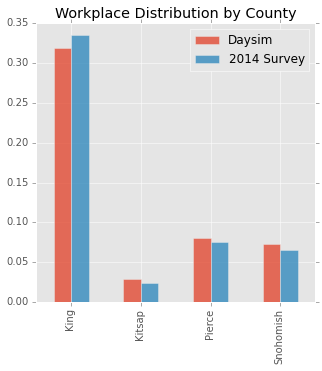

In [170]:
report_field('County', 'Workplace Distribution by County')

### Workplace Location by District

--------Totals--------

                          Daysim  2014 Survey  % Difference
East Side                 331061       341627        -0.03%
Everett-Lynwood-Edmonds   152032       134170         0.13%
Kitsap                    101795        79118         0.29%
North Seattle-Shoreline   142736       145550        -0.02%
Renton-FedWay-Kent        288721       236524         0.22%
S.Kitsap                   19895        14534         0.37%
Seattle CBD               247207       280301        -0.12%
South Pierce              144052       122157         0.18%
Suburban Snohomish        106822        85395         0.25%
Tacoma                    121606       117838         0.03%
West-South Seattle        130384       117025         0.11%
Total                    1786311      1674239         0.07%


-----Distribution-----

                         Daysim  2014 Survey  % Difference
East Side                 0.09%        0.10%        -0.09%
Everett-Lynwood-Edmonds   0.04%        0.04%        

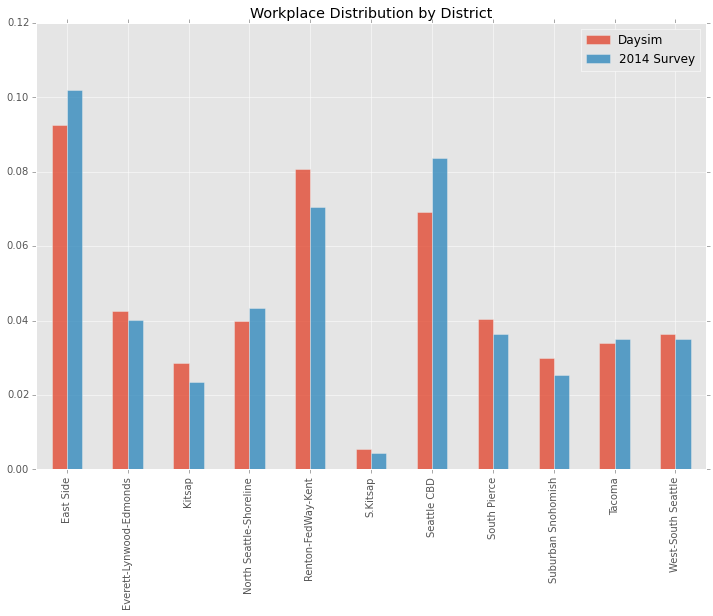

In [171]:
report_field('New DistrictName', title='Workplace Distribution by District', figsize=(12,8))

---

## School Location

In [177]:
# Join school geography
hh_per_scen_school_geog = pd.merge(hh_per_scen, taz_geog, left_on='School TAZ', right_on='TAZ')
hh_per_base_school_geog = pd.merge(hh_per_base, taz_geog, left_on='School TAZ', right_on='TAZ')

### By County

--------Totals--------

            Daysim  2014 Survey  % Difference
King       1140109      1121029         0.02%
Kitsap      101795        79118         0.29%
Pierce      285553       254531         0.12%
Snohomish   258854       219565         0.18%
Total      1786311      1674243         0.07%


-----Distribution-----

           Daysim  2014 Survey  % Difference
King        0.32%        0.33%        -0.05%
Kitsap      0.03%        0.02%         0.21%
Pierce      0.08%        0.08%         0.05%
Snohomish   0.07%        0.07%         0.10%
Total       0.50%        0.50%         0.00%



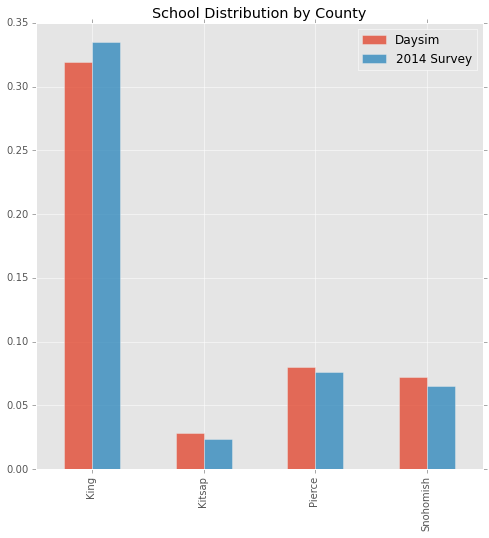

In [179]:
report_field('County', title='School Distribution by County', figsize=(8,8))

### School Location by District

--------Totals--------

                          Daysim  2014 Survey  % Difference
East Side                 331061       341627        -0.03%
Everett-Lynwood-Edmonds   152032       134170         0.13%
Kitsap                    101795        79118         0.29%
North Seattle-Shoreline   142736       145550        -0.02%
Renton-FedWay-Kent        288721       236524         0.22%
S.Kitsap                   19895        14534         0.37%
Seattle CBD               247207       280301        -0.12%
South Pierce              144052       122157         0.18%
Suburban Snohomish        106822        85395         0.25%
Tacoma                    121606       117838         0.03%
West-South Seattle        130384       117025         0.11%
Total                    1786311      1674239         0.07%


-----Distribution-----

                         Daysim  2014 Survey  % Difference
East Side                 0.09%        0.10%        -0.09%
Everett-Lynwood-Edmonds   0.04%        0.04%        

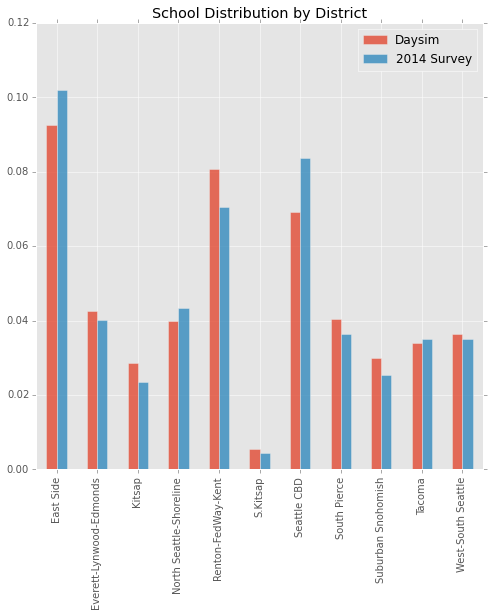

In [181]:
report_field('New DistrictName', title='School Distribution by District', figsize=(8,8))

# Transit Pass Ownership

### By Home Location

In [184]:
df = pd.DataFrame([person_scen.groupby('Transit Pass').sum()['Expansion Factor'],
              person_base.groupby('Transit Pass').sum()['Expansion Factor']]).T
df.columns=([scen_name,base_name])
df

,Daysim,2014 Survey
Transit Pass,,
-1,nan%,803664.21%
0,3088967.00%,2299667.16%
1,507572.00%,32549.10%
2,nan%,12850.18%
3,nan%,130055.65%
4,nan%,71807.30%
5,nan%,197035.35%
6,nan%,22704.85%


In [190]:
# By Home County
colname = 'Transit Pass'
df = pd.DataFrame([hh_per_scen_home_geog.groupby(colname).sum()['Expansion Factor_h'].astype('int'),
                   hh_per_base_home_geog.groupby(colname).sum()['Expansion Factor_h'].astype('int')]).T
df.columns=([scen_name,base_name])
df

,Daysim,2014 Survey
Transit Pass,,
-1,nan%,803314.00%
0,3088967.00%,2299667.00%
1,507572.00%,32549.00%
2,nan%,12850.00%
3,nan%,130055.00%
4,nan%,71807.00%
5,nan%,197035.00%
6,nan%,22704.00%


In [186]:
# By Home District
colname = 'New DistrictName'
df = pd.DataFrame([hh_per_scen_home_geog.groupby(colname).sum()['Expansion Factor_h'],
                   hh_per_base_home_geog.groupby(colname).sum()['Expansion Factor_h']]).T
df.columns=([scen_name,base_name])
df

,Daysim,2014 Survey
New DistrictName,,
East Side,611001.00%,660055.82%
Everett-Lynwood-Edmonds,266633.00%,260156.65%
Kitsap,245547.00%,235654.99%
North Seattle-Shoreline,310226.00%,347437.12%
Renton-FedWay-Kent,559730.00%,490533.63%
S.Kitsap,62578.00%,51829.92%
Seattle CBD,169722.00%,175700.03%
South Pierce,469960.00%,470790.10%
Suburban Snohomish,433112.00%,425073.22%


### By Work Location

In [187]:
# By Work County
colname = 'County'
df = pd.DataFrame([hh_per_scen_work_geog.groupby(colname).sum()['Expansion Factor_h'],
                   hh_per_base_work_geog.groupby(colname).sum()['Expansion Factor_h']]).T
df.columns=([scen_name,base_name])
df

,Daysim,2014 Survey
County,,
King,1140109.00%,1121029.16%
Kitsap,101795.00%,79118.02%
Pierce,285553.00%,254531.04%
Snohomish,258854.00%,219565.93%


In [74]:
# By Work District
colname = 'New DistrictName'
df = pd.DataFrame([hh_per_scen_work_geog.groupby(colname).sum()['Expansion Factor_h'],
                   hh_per_base_work_geog.groupby(colname).sum()['Expansion Factor_h']]).T
df.columns=([scen_name,base_name])
df

,2006 Survey,2014 Survey
New DistrictName,,
East Side,258650.11,341627.6864
Everett-Lynwood-Edmonds,122540.92,134170.2019
Kitsap,77365.82,79118.0230
North Seattle-Shoreline,122276.58,145550.0361
Renton-FedWay-Kent,215984.34,236524.1442
S.Kitsap,6998.18,14534.8730
Seattle CBD,221391.87,280301.7830
South Pierce,104619.23,122157.2120
Suburban Snohomish,76139.54,85395.7301


---

# Auto Ownership

In [75]:
new_hh_scen = hh_scen[hh_scen.index>=0]
df = pd.DataFrame([hh_scen.groupby('Household Vehicles').sum()['Expansion Factor'],
                   hh_base.groupby('Household Vehicles').sum()['Expansion Factor']]).T
df.columns=([scen_name,base_name])
df=df[df.index>=0]
df

,2006 Survey,2014 Survey
Household Vehicles,,
0,101740.92,116720.4270
1,443595.40,477848.3440
2,514038.70,560222.1101
3,212356.59,218361.4192
4,69227.00,72856.2619
5,23312.56,22097.4961
6,7270.14,2295.3940
7,2010.24,4625.1520
8,1233.62,1874.7780


In [76]:
df_new = pd.DataFrame([df[scen_name]/df[scen_name].sum(),
             df[base_name]/df[base_name].sum()]).T
df_new

,2006 Survey,2014 Survey
Household Vehicles,,
0,0.073962,0.078948
1,0.322476,0.323211
2,0.373685,0.378928
3,0.154375,0.147697
4,0.050325,0.049279
5,0.016947,0.014947
6,0.005285,0.001553
7,0.001461,0.003128
8,0.000897,0.001268


In [77]:
display_charts(df_new, kind='bar', title='Auto Ownership Distribution Regionwide')

In [78]:
# Average autos per household
print scen_name + ": " + str(sum(hh_scen['Household Vehicles']*hh_scen['Expansion Factor'])/sum(hh_scen['Expansion Factor']))
print base_name + ": " + str(sum(hh_base['Household Vehicles']*hh_base['Expansion Factor'])/sum(hh_base['Expansion Factor']))

2006 Survey: 1.8735651003
2014 Survey: 1.84776763947


In [79]:
# Auto Ownership by Income
# Create common income ranges
def map_income(df, in_field, out_field):
    
    # Define categories
    incmap = {}
    for i in range(0, 20000):
        incmap.update({i: ' <20k'})
    for i in range(20000, 40000):
        incmap.update({i: '20k-40k'})
    for i in range(40000, 60000):
        incmap.update({i: '40k-60k'})
    for i in range(60000, 75000):
        incmap.update({i: '60k-75k'})
    for i in range(75000, 100000):
        incmap.update({i: '75k-100k'})
    for i in range(100000, 150000):
        incmap.update({i: '100k-150k'})
    for i in range(150000, int(df[in_field].max())+1):
        incmap.update({i: '>150k'})

    df[out_field] = df[in_field].map(incmap)
    return df

In [80]:
hh_scen = map_income(hh_scen, in_field='Household Income', out_field='Income')
hh_base = map_income(hh_base, in_field='Household Income', out_field='Income')

In [81]:
hh_base.groupby('Household Income').count()

,Expansion Factor,Household ID,Household Size,Household TAZ,Household Vehicles,Household Workers,Income
Household Income,,,,,,,
-1,2395,2395,2395,2395,2395,2395,0
5000,225,225,225,225,225,225,225
12500,14,14,14,14,14,14,14
17500,513,513,513,513,513,513,513
30000,455,455,455,455,455,455,455
37500,42,42,42,42,42,42,42
40000,642,642,642,642,642,642,642
62500,1035,1035,1035,1035,1035,1035,1035
87500,862,862,862,862,862,862,862


In [82]:
df_scen = pd.pivot_table(data=hh_scen, index='Household Vehicles', columns=['Income'], 
                    aggfunc='sum', values='Expansion Factor', fill_value=False, margins=False)
df_base = pd.pivot_table(data=hh_base, index='Household Vehicles', columns=['Income'], 
                    aggfunc='sum', values='Expansion Factor', fill_value=False, margins=False)
# Sort the columns
df_scen = df_scen[[' <20k','20k-40k','40k-60k','60k-75k',
                   '75k-100k','100k-150k','>150k']]
df_base = df_base[[' <20k','20k-40k','40k-60k','60k-75k',
                   '75k-100k','100k-150k','>150k']]

In [83]:
# Calculate averages by income class
df = pd.DataFrame([[sum(df_scen[colname]*df_scen.index)/sum(df_scen[colname]) for colname in df_scen.columns],
                    [sum(df_base[colname]*df_base.index)/sum(df_base[colname]) for colname in df_base.columns]]).T
df.index=df_base.columns
df.columns=[scen_name,base_name]
df['% difference 2006->2014']= (df[base_name]-df[scen_name])/df[scen_name]
df

,2006 Survey,2014 Survey,% difference 2006->2014
Income,,,
<20k,0.826999,1.005473,0.215810
20k-40k,1.353486,1.361532,0.005945
40k-60k,1.843047,1.604677,-0.129334
60k-75k,2.071737,1.851326,-0.106390
75k-100k,2.337899,2.208299,-0.055434
100k-150k,2.564529,2.367576,-0.076799
>150k,2.533331,2.634852,0.040074


In [84]:
hh_per_scen_home_geog.columns

Index([u'Age', u'Auto Distance to Work', u'Auto Time to Work', u'Expansion Factor_p', u'Household ID', u'Person Number', u'Person Type', u'School TAZ', u'Student Type', u'Transit Pass', u'Usual Commute Mode', u'Worker Type', u'Workplace TAZ', u'personID', u'Expansion Factor_h', u'Household Income', u'Household Size', u'Household TAZ', u'Household Vehicles', u'Household Workers', u'TAZ', u'TAD', u'OldDistric', u'County', u'District', u'New DistrictName'], dtype='object')

In [85]:
# Average ownership by district
df_scen = pd.pivot_table(data=hh_per_scen_home_geog, index='Household Vehicles', columns=['New DistrictName'], 
                    aggfunc='sum', values='Expansion Factor_p', fill_value=False, margins=False)
df_base = pd.pivot_table(data=hh_per_base_home_geog, index='Household Vehicles', columns=['New DistrictName'], 
                    aggfunc='sum', values='Expansion Factor_p', fill_value=False, margins=False)

In [86]:
# Calculate averages by district
df = pd.DataFrame([[sum(df_scen[colname]*df_scen.index)/sum(df_scen[colname]) for colname in df_scen.columns],
                    [sum(df_base[colname]*df_base.index)/sum(df_base[colname]) for colname in df_base.columns]]).T
df.index=df_base.columns
df.columns=[scen_name,base_name]
df
df['% difference 2006->2014']= (df[base_name]-df[scen_name])/df[scen_name]
df

,2006 Survey,2014 Survey,% difference 2006->2014
New DistrictName,,,
East Side,2.226978,2.267642,0.018260
Everett-Lynwood-Edmonds,1.985693,1.000000,-0.496398
Kitsap,2.368156,2.214412,-0.064921
North Seattle-Shoreline,1.899898,1.806059,-0.049392
Renton-FedWay-Kent,2.214294,2.214888,0.000269
S.Kitsap,1.966543,2.570041,0.306883
Seattle CBD,1.368956,1.282108,-0.063441
South Pierce,2.241079,2.317545,0.034120
Suburban Snohomish,2.670453,2.360578,-0.116038


In [48]:
# Average ownership by county
df_scen = pd.pivot_table(data=hh_per_scen_home_geog, index='Household Vehicles', columns=['County'], 
                    aggfunc='sum', values='Expansion Factor_p', fill_value=False, margins=False)
df_base = pd.pivot_table(data=hh_per_base_home_geog, index='Household Vehicles', columns=['County'], 
                    aggfunc='sum', values='Expansion Factor_p', fill_value=False, margins=False)

In [49]:
# Calculate averages by county
df = pd.DataFrame([[sum(df_scen[colname]*df_scen.index)/sum(df_scen[colname]) for colname in df_scen.columns],
                    [sum(df_base[colname]*df_base.index)/sum(df_base[colname]) for colname in df_base.columns]]).T
df.index=df_base.columns
df.columns=[scen_name,base_name]
df
df['% difference 2006->2014']= (df[base_name]-df[scen_name])/df[scen_name]
df

,2006 Survey,2014 Survey,% difference 2006->2014
County,,,
King,2.053105,2.044368,-0.004256
Kitsap,2.368156,2.214412,-0.064921
Pierce,2.180297,2.250480,0.032189
Snohomish,2.399664,2.206878,-0.080339
